In [70]:
# PSF
from operator import mul as _opmul
from functools import partial, reduce
from itertools import product as _prod, combinations as _comb, combinations_with_replacement as _combu, starmap as _star
from multiprocessing import Pool
from timeit import timeit, default_timer as timer

# Math
import numpy as np
import numpy.linalg as la
from scipy.special import comb
from scipy.linalg import blas

# Plotting Packages
import matplotlib.pyplot as plt

# Widgets
import ipywidgets as widgets

import time

In [71]:
def trace_layout(traces, moment):
    tr_count, tr_len = len(traces), len(traces[0])
    dtype=np.promote_types(np.result_type(traces[0][0]), 'i8')
    trace_copy = np.empty((tr_count, 2 * moment * tr_len + 1), dtype=dtype)
    trace_copy[:] = -1
    trace_copy[:, 0] = 1
    trace_copy_view = trace_copy[:, 1:].reshape(tr_count, 2 * moment, tr_len)
    for i, tr in enumerate(traces):
        trace_copy_view[i, 0] = tr
    trace_copy = trace_copy.reshape(tr_count, 2 * moment * tr_len + 1)
    LS, l = trace_copy.T.tolist(), tr_len
    for j in range(1, 2 * moment):
        for i in range(tr_len):
            LS[1+(j)*l:1+(j+1)*l][i][:] = vmul(LS[1+0*l:1+1*l][i], LS[1+(j-1)*l:1+(j)*l][i])
    return LS

def c_layout(cls):
    tr_count, cl_len = len(cls), len(cls[0])
    dtype=np.promote_types(np.result_type(cls[0][0]), 'i8')
    c_copy = np.empty((tr_count, cl_len + 1), dtype=dtype)
    c_copy[:] = -1
    c_copy[:, 0] = 1
    c_copy_view = c_copy[:, 1:].reshape(tr_count, cl_len)
    for i, tt in enumerate(cls):
        c_copy_view[i] = tt
    c_copy = c_copy.reshape(tr_count, cl_len + 1)
    LS = c_copy.T.tolist()
    return LS

def trace_layout_np(traces, moment):
    tr_count, tr_len = len(traces), len(traces[0])
    dtype=np.promote_types(np.result_type(traces[0][0]), 'i8')
    trace_copy = np.empty((tr_count, 2 * moment * tr_len + 1), dtype=dtype)
    trace_copy[:] = -1
    trace_copy[:, 0] = 1
    trace_copy_view = trace_copy[:, 1:].reshape(tr_count, 2 * moment, tr_len)
    for i, tr in enumerate(traces):
        trace_copy_view[i, 0] = tr
    trace_copy = trace_copy.reshape(tr_count, 2 * moment * tr_len + 1)
    for j in range(1, 2 * moment):
        np.multiply(trace_copy_view[:, 0, :], trace_copy_view[:, j - 1, :], trace_copy_view[:, j, :])
    
    return trace_copy

    
def c_layout_np(cls):
    tr_count, cl_len = len(cls), len(cls[0])
    dtype=np.promote_types(np.result_type(cls[0][0]), 'i8')
    cls_copy = np.empty((tr_count, cl_len + 1), dtype=dtype)
    cls_copy[:] = -1
    cls_copy[:, 0] = 1
    cls_copy_view = cls_copy[:, 1:].reshape(tr_count, cl_len)
    for i, tt in enumerate(cls):
        cls_copy_view[i] = tt
    cls_copy = cls_copy.reshape(tr_count, cl_len + 1)
    
    return cls_copy

In [72]:


def binom(N, k):
    return comb(N, k, exact=True)

def vmul(x, y):
    """Vectorized (sort-of) element-wise multiplication"""
    return map(_opmul, x, y)

def summul_gen():
    _compose_star = lambda f, g: lambda *args: f(g(*args))
    return reduce(_compose_star, (sum, partial(map, _opmul)))  # "Vectorized" dot-product

summul = summul_gen()

def mmuls(A, B):
    """Square matrix multiplication of A'*B"""
    return [[summul(_b, _a) for _b in B] for _a in A]        # fastest 700x10, 20x10k)



In [73]:
def _get_mom(row, tr_len, k):
    """Returns i-powered sums for each point in trace"""
    return row[1 + (k - 1)*tr_len:][:tr_len]

def sums2moms(bin, moment):
    trace = True
    tr_len = (len(bin[0]) - 1) // moment // 2
    h_len = len(bin) - 1
    N_T = bin[0][0]
    CM = [[] for _ in range(h_len)]
    for M, CMh in zip(bin[1:], CM):
        N_1 = M[0]
        N_0 = N_T - N_1
        M0 = _get_mom(M, tr_len, 1)
        for m in range(2 * moment, 0, -1):
            if m==9: print("\n moment #", m, "\n")
            inv_N1 = 1.0 / (N_1 ** m)
            mom_m = _get_mom(M, tr_len, m)
            res1, res2, res3  = [[] for _ in range(tr_len)], [[] for _ in range(tr_len)], [[] for _ in range(tr_len)]
            for i in range(0, tr_len):
                for k in range(2, m):
                    m_inner = M0[i] ** (m - k)
                    mom_k = _get_mom(M, tr_len, k)
                    elem0 = N_1 ** (k - 1) * (-1) ** (m - k) * binom(m, k) * mom_k[i] * m_inner
                    res1[i].append(elem0)
                    if m==9: print('\t{:5.3e} {:+22.16e}, {:7}**{:2d} = {:+22.16e}, := {:+22.16e}'.format(N_1 ** (k - 1), mom_k[i], M0[i], (m - k), m_inner, elem0))
                m_edge = M0[i] ** m
                elem1 = (-1) ** (m - 1) * (m - 1) * m_edge
                res2[i] = elem1
                if m==9: print('\n \t{:2d} * [{:7}**{:2d} = {:+22.16e}], := {:+22.16e}'.format(m - 1, M0[i], m, m_edge, elem1))
                res3[i] = sum(res1[i])              # Sum up products of intermediate degrees
                if m==9: print("\n Mixed products summed up:  ", ['{:+22.16e}'.format(r) for r in res3])
                if m==9: print("------------------------------------------------------")  
                res = res2[i] + res3[i]
                mom_m[i] *= N_1 ** (m - 1)
                if m==9: print("Final int sum and inv_n:    ", '{:+22.16e}'.format(res+mom_m[i]), inv_N1)

                mom_m[i] += res
                mom_m[i] *= inv_N1  #int -> float
                # print(type(mom_m[i]))
                # if(stages_dt == 32):
                #     mom_m[i] = np.float32(mom_m[i])
                
                CMh.insert(0, mom_m[i])
            if m==9: print('=========================================================')
    return CM

In [74]:

def stages_fine(a, cls, moment):
    stages_dt = 64
    av = trace_layout(a.tolist(), moment)
    cv = c_layout(cls.tolist())
    bin_fine = mmuls(cv, av)
    res_fine = sums2moms(bin_fine, moment)
    return av, bin_fine, res_fine

def stages_float_sums(a, cls, moment, stages_dt=None):
    
    af = trace_layout_np(a.astype(np.float64), moment)
    cf = c_layout_np(cls.astype(np.float64))
    bin_sums = np.dot(cf.T, af)
        
    res_float = sums2moms(bin_sums, moment)
    return af.T, bin_sums, res_float

def stages_float_detrend(a, cls, moment, stages_dt):
    ap, base_sample = a, 10
    am = np.mean(a[:base_sample], axis=0).astype(np.int32)
    a = a - am

    
    
    if stages_dt == 32:
        adt = trace_layout_np(a.astype(np.float32), moment)
        cf = c_layout_np(cls.astype(np.float32))
        bin_sums = np.dot(cf.T, adt)
        res_bin_dt = np.array(bin_sums).astype(np.float32)
    else:
        adt = trace_layout_np(a.astype(np.float64), moment)
        cf = c_layout_np(cls.astype(np.float64))
        bin_sums = np.dot(cf.T, adt)
        res_bin_dt = bin_sums
        
    res_float_dt = sums2moms(res_bin_dt, moment)


    res_float_dt = np.asarray(res_float_dt)
    res_float_dt[:,0] += am
    # print("stages_float_detrend")
    # print("a before: {}".format(ap[:base_sample]))
    # print("a mean:   {}".format(am[:base_sample]))
    # print("a after:  {}".format(a[:base_sample]))
    return adt, res_bin_dt, res_float_dt

In [75]:
# def error_estimation(fine, real, moment):
#     tr_len = len(fine[0]) // 2 // moment
#     # Abs err
#     abs_err = [[np.max(np.abs(_get_mom(fine[i], tr_len, m) - _get_mom(real[i], tr_len, m))) for m in range(2*moment)] for i in range len(fine[0])] 
#     # Rel err
#     max_fine = np.max(np.abs(fine).astype(np.float64), axis=2)
#     print(max_fine)
#     return abs_err, abs_err / max_fine


In [76]:

def error_estimation(fine, real):
    """m is unused"""
    # Abs err
    abs_err = np.abs(fine - real).astype(np.float64)
    # Rel err
    max_fine = np.empty(np.shape(fine[0]))
    fine_t = fine.T
    for i, row in enumerate(fine_t):
        max_fine[i] = np.abs(np.amax(row))
    rel_err = abs_err / max_fine
    return abs_err, rel_err


In [77]:
def plot_err(mom_rerr, acc_rerr, moment, tr_len, cl_len, cmap=None, vmin1=1e-16, vmin2=1e-16, vmax=0e-1, fnum=None):
    fnum = fnum if fnum is not None else 0.0
    cmap = cmap if cmap is not None else 'Reds'

            
    
    fig1, axe1 = plt.subplots(1,1, figsize=(10, 5), tight_layout=True)
    fig2, axe2 = plt.subplots(1,1, figsize=(10, 5), tight_layout=True)
    im1 = axe1.imshow(acc_rerr, 'cividis', vmin=vmin1, vmax=vmax)
    im2 = axe2.imshow(mom_rerr, cmap, vmin=vmin2, vmax=vmax)
    axe1.set_title("Accumulator")
    axe2.set_title("Moments")
    
    axe1.set_xticks(np.arange(-0.5, 2*moment*tr_len, tr_len))
    axe1.set_yticks(np.arange(-0.5, cl_len, tr_len))
    axe1.set_xticklabels([])
    axe1.set_yticklabels([])
    axe1.grid(linewidth=1, color='red')

    axe2.set_xticks(np.arange(-0.5, 2*moment*tr_len, tr_len))
    axe2.set_yticks(np.arange(-0.5, cl_len, tr_len))
    axe2.set_xticklabels([])
    axe2.set_yticklabels([])
    axe2.grid(linewidth=1, color='red')

    fig1.colorbar(im1)
    fig2.colorbar(im2)

def stage_err(a, cls, m, stages_func):
    global_dt = 32
    _, afine, sfine = stages_fine(a, cls, m)    # Arbitrary precise integers
    _, afloat, sfloat = stages_func(a, cls, m, global_dt)   # double
    sfine_np, sfloat_np = np.array(sfine), np.array(sfloat)
    afine_np, afloat_np = np.array(afine), np.array(afloat)
    afine_np, afloat_np = afine_np[1:,1:], afloat_np[1:,1:]
    _, res_acc = error_estimation(afine_np, afloat_np)
    _, res_mom = error_estimation(sfine_np, sfloat_np)
    return res_acc, res_mom

def error_interact_uniform(tr_cnt, param1, param2):
    # Uniform distribution
    tr_len, moment = 1, 4
    cl_len = 4
    lo, hi = param1, param2
    a = np.random.randint(lo, hi, (tr_cnt, tr_len)).astype(dtype=np.int64)
    cls = np.random.randint(0, 2, (tr_cnt, cl_len)).astype(dtype=np.int8)
    rerr_acc, rerr_mom = stage_err(a, cls, moment, stages_float_sums)
    plot_err_setup(tr_len, cl_len, rerr_mom, rerr_acc)

def error_interact_gauss(tr_cnt, param1, param2):
    # Gauss distribution
    tr_len, moment = 1, 4
    cl_len = 4
    loc, scale = param1, param2
    a = np.random.normal(loc, scale, (tr_cnt, tr_len)).astype(dtype=np.int64)
    cls = np.random.randint(0, 2, (tr_cnt, cl_len)).astype(dtype=np.int8)
    rerr_acc, rerr_mom = stage_err(a, cls, moment, stages_float_sums)
    plot_err_setup(tr_len, cl_len, rerr_mom, rerr_acc)

def error_interact_gauss_detrend(tr_cnt, param1, param2):
    # Gauss with detrend
    tr_len, moment = 1, 4
    cl_len = 4
    loc, scale = param1, param2
    a = np.random.normal(loc, scale, (tr_cnt, tr_len)).astype(dtype=np.int64)
    cls = np.random.randint(0, 2, (tr_cnt, cl_len)).astype(dtype=np.int8)
    rerr_acc, rerr_mom = stage_err(a, cls, moment, stages_float_detrend)
    plot_err_setup(tr_len, cl_len, rerr_mom, rerr_acc)

def plot_err_setup(tr_len, cl_len, rerr_com_sum, rerr_acc):
    pargs = { 'cmap' :'coolwarm','vmin1': -16, 'vmin2': -16, 'vmax' : 0, 'fnum' : -100 }
    rerr_log = np.log10(rerr_com_sum + 1.0e-32)
    rerr_acc_log = np.log10(rerr_acc + 1.0e-32)
    plot_err(rerr_log, rerr_acc_log, moment, tr_len, cl_len, **pargs)

# Main

In [78]:
moment = 4  # All powers for E((x-a)^m*(y-b)^m)
tr_cnt, tr_len = 5000, 1
cl_len = 4
global_dt = 32

seedtime = int(time.time())
np.random.seed(1020)

# Normal distribution
loc, scale = 10000, 1000  # Std less than 2% of mean leads to instability
a = np.random.normal(loc, scale, (tr_cnt, tr_len)).astype(dtype=np.int64)
cls = np.random.randint(0, 2, (tr_cnt, cl_len)).astype(dtype=np.int8)
seedtime

1663236696

In [79]:
# %%time
layout_fine, sums_fine, com_fine = stages_fine(a, cls, moment)
sums_fine_np = np.array(sums_fine)
sums_fine_np = sums_fine_np[1:,1:]
com_fine_np = np.array(com_fine)

In [80]:
# %%time
layout_float, sums_float, com_float = stages_float_sums(a, cls, moment, 64)
sums_float_np = np.array(sums_float)
sums_float_np = sums_float_np[1:,1:]
com_float_np = np.array(com_float)

In [81]:
# %%time
layout_float_off, sums_float_off, com_float_off = stages_float_detrend(a, cls, moment, global_dt)
sums_float_off_np = np.array(sums_float_off)
sums_float_off_np = sums_float_off_np[1:,1:]
com_float_off_np = np.array(com_float_off)

In [82]:
# print(sums_fine_np[1, 1:], "\n \n", sums_float_np[1, 1:])

In [83]:
print("Non-off method rel errors")
_, rerr_com = error_estimation(com_fine_np, com_float_np)
_, rerr_sum = error_estimation(sums_fine_np, sums_float_np)

Non-off method rel errors


In [84]:

print("Off-base method rel errors")
_, rerr_com_off = error_estimation(com_fine_np, com_float_off_np)
_, rerr_sum_off = error_estimation(sums_fine_np, sums_float_off_np)

Off-base method rel errors


# Log error visualization

-32.0 -6.120695504851203


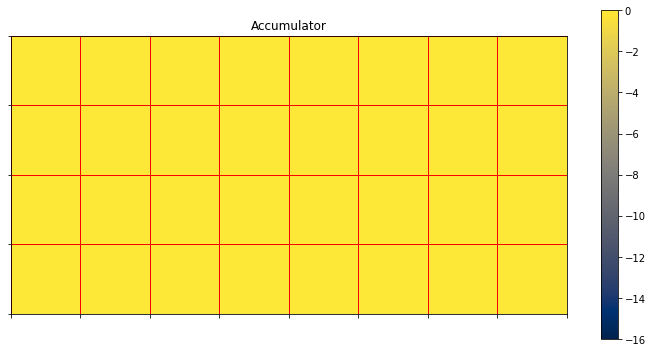

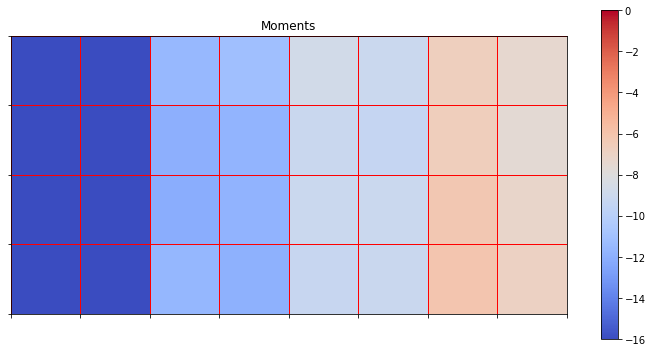

In [85]:
# Straight-forward method
rerr_com_log = np.log10(rerr_com + 1.0e-32)
rerr_sum_log = np.log10(rerr_sum + 1.0e-32)
print(np.min(rerr_com_log), np.max(rerr_com_log))
plot_err(rerr_com_log, rerr_sum_log, moment, tr_len, cl_len, cmap='coolwarm',vmin1=-16, vmin2=-16, vmax=0, fnum=-100)

-9.576200210538678 inf


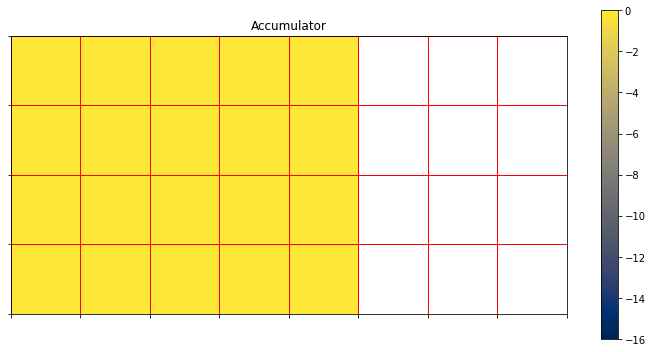

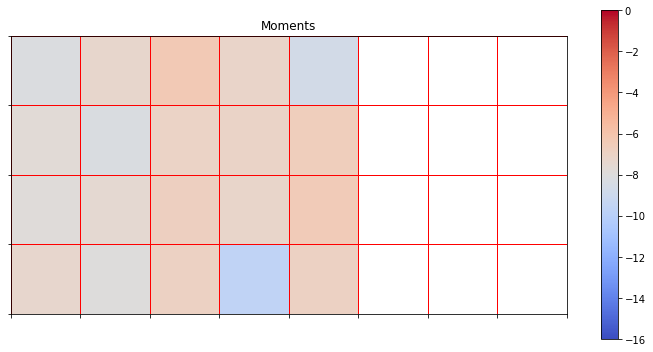

In [86]:
# Off-base approach
rerr_com_off_log = np.log10(rerr_com_off + 1.0e-32)
rerr_sum_off_log = np.log10(rerr_sum_off + 1.0e-32)
print(np.min(rerr_com_off_log), np.max(rerr_com_off_log))
plot_err(rerr_com_off_log, rerr_sum_off_log, moment, tr_len, cl_len, cmap='coolwarm',vmin1=-16, vmin2=-16, vmax=0, fnum=-100)


# Interactive

In [87]:
# Univariate distribution
# dparams = [{'value': 10_000, 'min':100,     'max':100_000, 'step':1000, 'description':'Count'},
#            {'value': 19_000, 'min':-30_000, 'max':40_000,  'step':20,   'description':'LBound'},
#            {'value': 21_000, 'min':-30_000, 'max':40_000,  'step':20,   'description':'UBound'} ]
# cnt_wdgt, p1_wdgt, p2_wdgt = [
# widgets.IntSlider(**dparams[0], continuous_update=False, layout=widgets.Layout(width='750px')),
# widgets.IntSlider(**dparams[1], continuous_update=False, layout=widgets.Layout(width='750px')),
# widgets.IntSlider(**dparams[2], continuous_update=False, layout=widgets.Layout(width='750px'))] 

# widgets.interactive(error_interact_uniform, tr_cnt=cnt_wdgt, param1=p1_wdgt, param2=p2_wdgt)

In [88]:
# Gaussian distribution
# dparams = [{'value': 5000, 'min':0,   'max':600_000, 'step':1000, 'description':'Count'},
#            {'value': 10000, 'min':0,   'max':30_000,  'step':100,  'description':'mean'},
#            {'value': 1000,   'min':0,   'max':5_000,   'step':100,   'description':'std'} ]
# cnt_wdgt, p1_wdgt, p2_wdgt = [
# widgets.IntSlider(**dparams[0], continuous_update=False, layout=widgets.Layout(width='70%')),
# widgets.IntSlider(**dparams[1], continuous_update=False, layout=widgets.Layout(width='70%')),
# widgets.IntSlider(**dparams[2], continuous_update=False, layout=widgets.Layout(width='70%'))]

# widgets.interactive(error_interact_gauss, tr_cnt=cnt_wdgt, param1=p1_wdgt, param2=p2_wdgt)

In [89]:
# Gaussian distribution with detrend
dparams = [{'value': 5000, 'min':0,   'max':600_000, 'step':1000, 'description':'Count'},
           {'value': 128, 'min':0,   'max':30_000,  'step':100,  'description':'mean'},
           {'value': 12,   'min':0,   'max':5_000,   'step':100,   'description':'std'} ]
cnt_wdgt, p1_wdgt, p2_wdgt = [
    widgets.IntSlider(**dparams[0], continuous_update=False, layout=widgets.Layout(width='70%')),
    widgets.IntSlider(**dparams[1], continuous_update=False, layout=widgets.Layout(width='70%')),
    widgets.IntSlider(**dparams[2], continuous_update=False, layout=widgets.Layout(width='70%'))]

widgets.interactive(error_interact_gauss_detrend, tr_cnt=cnt_wdgt, param1=p1_wdgt, param2=p2_wdgt, stage=2)

interactive(children=(IntSlider(value=5000, continuous_update=False, description='Count', layout=Layout(width=…